Business Case
- Assuming you are working in a bank as a trader.
- You need to predict if the bond index so that you could take position (buy low sell high).
- You are to create the time series predictive model using machine learning model.
- Remember to split train test.
- Measurement is RMSE.
- Data visualization is needed. 
- Machine learning model should include MA, Exponential Smoothing, Holt, Winter, SARIMA, compose decompose.
- You are required to plot the prediction.
- Also, explain the pros and cons about your model, including limitation (can be both quantitative and qualitative).
- How to overcome the weakness of your model (future study).
The important of your model to the bank.

In [105]:
import pandas as pd

In [106]:
df = pd.read_csv("/content/drive/MyDrive/Bond Index Europe.csv")

In [107]:
df.head()

,DATE,BAMLHE00EHYITRIV
0,2017-02-23,289.82
1,2017-02-24,289.86
2,2017-02-27,289.98
3,2017-02-28,290.09
4,2017-03-01,290.36


In [108]:
df = df.drop(['DATE'], axis=1)
df.iloc[:,0]=pd.to_numeric(df.iloc[:,0], errors="coerce")
df = df.dropna()
df = df.interpolate()
column_name = df.columns[0]

In [109]:
df.describe()

,BAMLHE00EHYITRIV
count,1307.000000
mean,316.030719
std,18.608273
min,263.240000
25%,302.440000
50%,311.190000
75%,331.450000
max,349.830000


<Axes: >

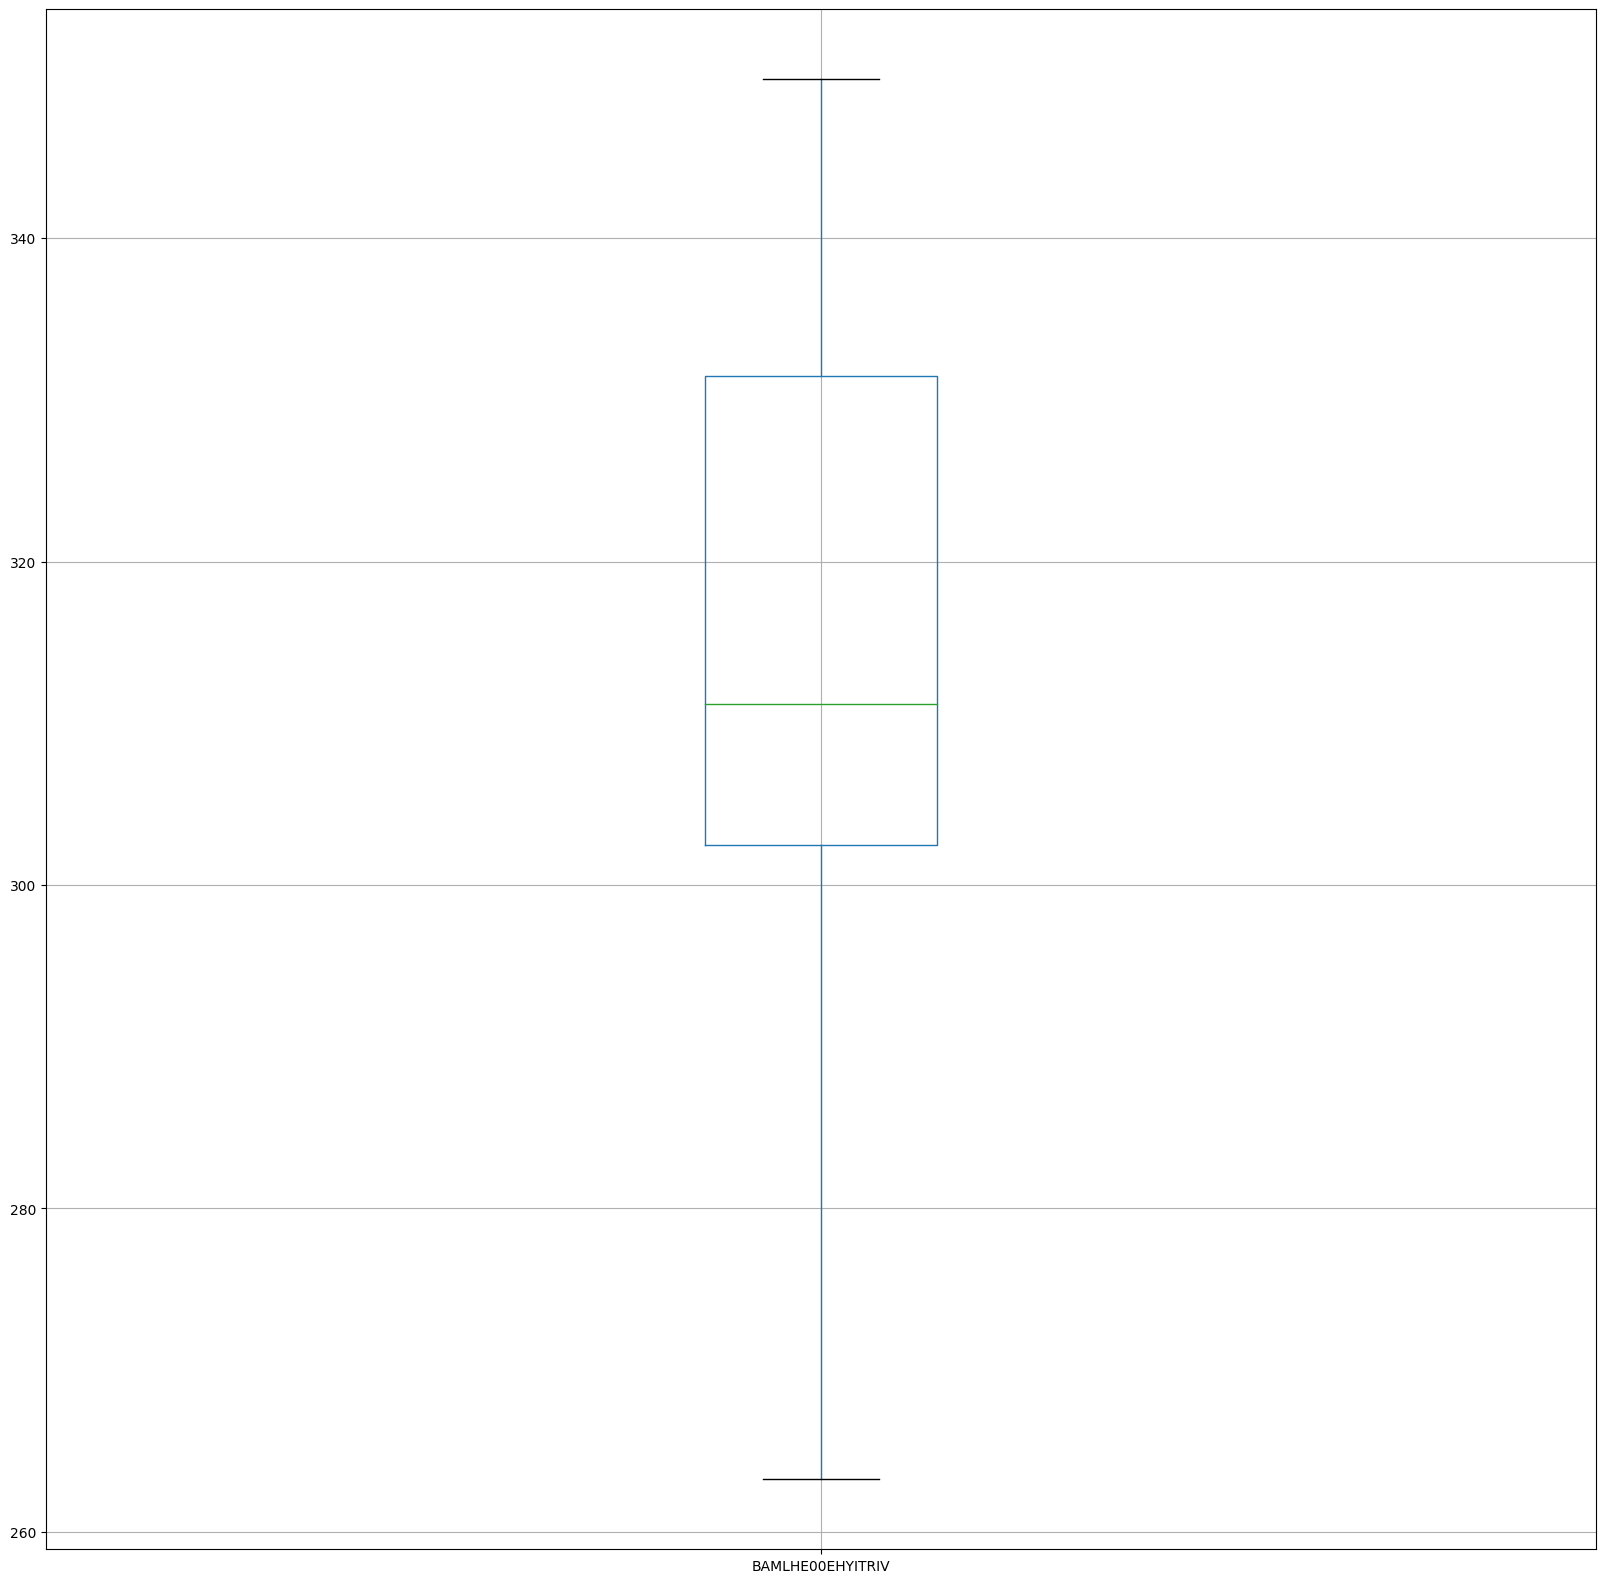

In [133]:
df.boxplot(figsize=(20,20))

In [110]:
column_name

'BAMLHE00EHYITRIV'

In [111]:
n_row=len(df)
train_row = int(0.8 * n_row)
train = df[0:train_row]
test = df[train_row:]

<Axes: >

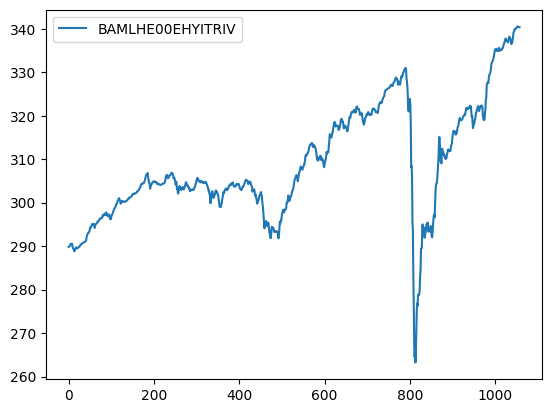

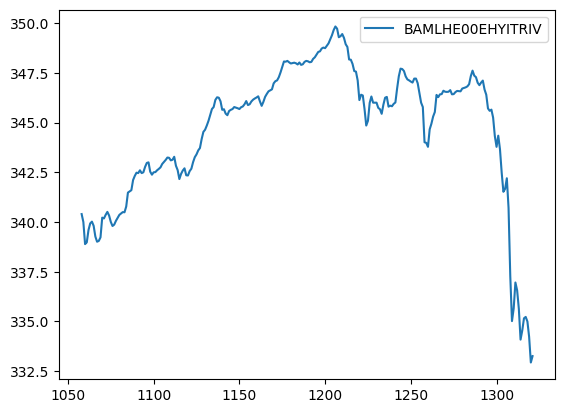

In [112]:
train.plot()
test.plot()

In [113]:
from statsmodels.tsa.stattools import adfuller

dicky = adfuller(df)
print(dicky[1])

0.49228291046486866


In [114]:
#MA

from sklearn.metrics import mean_squared_error

pred = test.copy()
pred['MA'] = train.iloc[:,0].rolling(10).mean().iloc[-1]

mean_squared_error(pred['MA'],test[column_name])**0.5


5.539026911811401

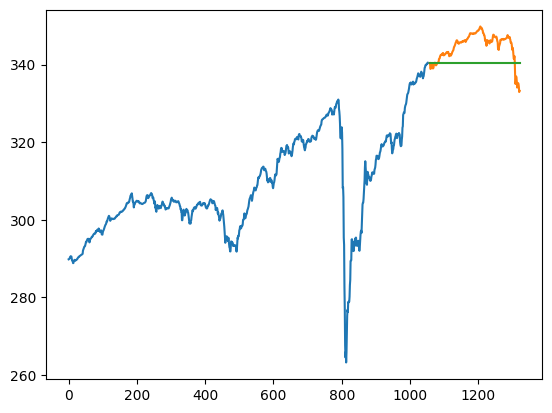

In [115]:
import matplotlib.pyplot as plt 

plt.plot(train)
plt.plot(test)
plt.plot(pred['MA'])
plt.show()

In [116]:
#ES

from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
import numpy as np

model = SimpleExpSmoothing(np.asarray(train.iloc[:,0])).fit(smoothing_level=0.9) 
#0.6 is for y(t-1) and 0.4 is for y(t-1 and below)
pred['ES'] = model.forecast(len(test))

mean_squared_error(pred['ES'],test[column_name])**0.5

5.514658829388858

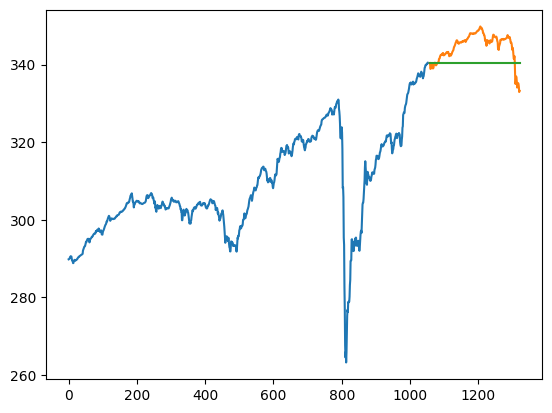

In [117]:
plt.plot(train)
plt.plot(test)
plt.plot(pred['ES'])
plt.show()

In [118]:
#Holt

model = Holt(np.asarray(train.iloc[:,0])).fit(smoothing_level = 0.9,smoothing_slope = 0.001)  
pred['Holt'] = model.forecast(len(test))
mean_squared_error(pred['Holt'],test[column_name])**0.5


<ipython-input-118-7ff8f26ce9c8>:3: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model = Holt(np.asarray(train.iloc[:,0])).fit(smoothing_level = 0.9,smoothing_slope = 0.001)


5.525890463178729

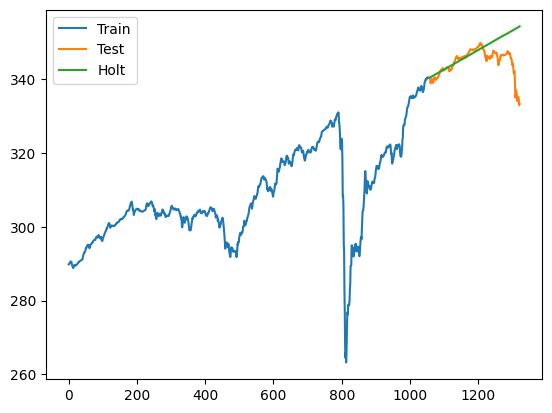

In [119]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred['Holt'], label='Holt')
plt.legend(loc='best')
plt.show()

In [120]:
#Holt Winter

model = ExponentialSmoothing(train, trend='add').fit()
pred['Holt_Winter'] = model.forecast(len(test))
pred = pred.dropna()
mean_squared_error(pred['Holt_Winter'],pred[column_name])**0.5


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


8.104981088627367

In [121]:
#SARIMA

import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(train.iloc[:,0], order=(1, 1,1),seasonal_order=(2,2,2,2)).fit()

pred['SARIMA'] = model.forecast(len(test))

mean_squared_error(pred['SARIMA'],pred[column_name])**0.5



/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


11.70344479386955

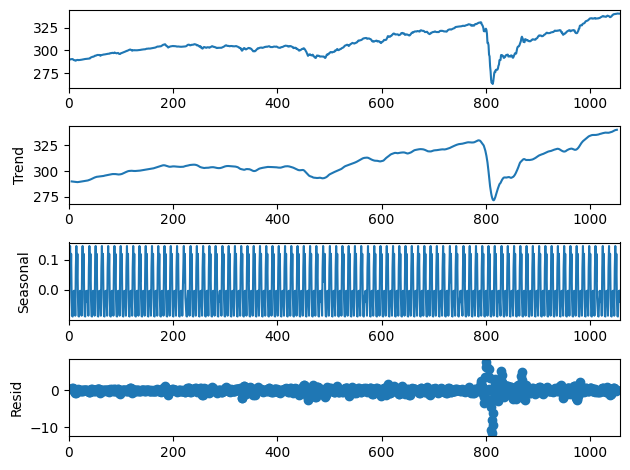

In [122]:
#decompose

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(train, model='additive', period=12)
trend = decomposition.trend.dropna()
seasonal=decomposition.seasonal.dropna()
residual=decomposition.resid.dropna()

decomposition.plot()
plt.show()


In [123]:
result = adfuller(residual)
print('p-value: %f' % result[1]) 


p-value: 0.000000


In [124]:
#compose back

pred =  trend + seasonal + residual

pred = pred.dropna()[-len(test):]

print(pred)
print(test)
mean_squared_error(pred, test[column_name])**0.5


787     330.57
788     330.50
789     330.72
790     331.00
791     330.69
         ...  
1047    339.85
1048    340.04
1049    340.19
1050    340.17
1051    340.38
Length: 262, dtype: float64
      BAMLHE00EHYITRIV
1058            340.40
1059            340.00
1060            338.89
1061            338.98
1062            339.60
...                ...
1317            335.23
1318            335.00
1319            334.23
1320            332.94
1321            333.26

[262 rows x 1 columns]


33.358237025971796

In [125]:
decomposition = seasonal_decompose(train, model='multiplicative', period=2)
trend = decomposition.trend.dropna()
seasonal=decomposition.seasonal.dropna()
residual=decomposition.resid.dropna()

#Without Customization (On Test Set) Additive
pred =  1.001*trend*seasonal*residual

pred = pred.dropna()[-len(test):]

mean_squared_error(pred, test[column_name])**0.5



32.90500819668068

Pros and Cons of the models:

1. Moving Average (MA):
Moving average is a simple time-series forecasting model that calculates the average of a specific number of periods of historical data and uses it as the prediction for the next period. The advantage of this model is its simplicity and ease of implementation. It works well when the data has a clear trend or seasonality and can be adjusted to different time periods to improve accuracy. However, this model assumes that the data has a constant mean and ignores any underlying trend, which can limit its ability to accurately forecast more complex relationships between variables. Additionally, MA may not work well for data with irregular fluctuations and can be sensitive to outliers.

2. Exponential Smoothing:
Exponential smoothing is a time-series forecasting model that uses a weighted average of past observations, with more recent observations being weighted more heavily than older ones. This model is simple and easy to implement, and can be adjusted to different time periods to improve accuracy. Exponential smoothing can capture both trend and seasonality in the data, but like MA, it assumes that the data has a constant mean and ignores any underlying trend. It may not work well for data with irregular fluctuations and can be sensitive to outliers.

3. Holt's Linear Method:
Holt's Linear Method is an extension of exponential smoothing that allows for the trend to be adjusted over time. This model can capture both trend and seasonality in the data, and can be adjusted to different time periods to improve accuracy. The advantage of Holt's Linear Method is its ability to allow for the trend to be adjusted over time. However, like other models that assume a constant mean, it may not work well for data with irregular fluctuations and can be sensitive to outliers.

4. Winter's Method:
Winter's Method is an extension of Holt's Linear Method that allows for the trend and seasonality to be adjusted over time. This model can capture both trend and seasonality in the data, and can be adjusted to different time periods to improve accuracy. The advantage of Winter's Method is its ability to allow for the trend and seasonality to be adjusted over time. However, like other models that assume a constant mean, it may not work well for data with irregular fluctuations and can be sensitive to outliers.

5. Seasonal Autoregressive Integrated Moving Average (SARIMA):
SARIMA is a time-series forecasting model that can handle non-stationary data and can capture both trend and seasonality in the data. SARIMA allows for the trend and seasonality to be adjusted over time and can be adjusted to different time periods to improve accuracy. However, SARIMA can be difficult to determine the appropriate model parameters, and it may not work well for data with irregular fluctuations.

6. Compose Decompose:
Compose Decompose is a time-series forecasting model that separates the different components of the time series (trend, seasonality, noise) and analyzes them independently. This model can allow for the trend and seasonality to be adjusted over time. The advantage of Compose Decompose is its ability to separate the different components of the time series and analyze them independently. However, like other models that assume a constant mean, it may not work well for data with irregular fluctuations and can be sensitive to outliers.

How to overcome weakness and importance of model 

One potential area of future research is the development of more advanced models that can capture the complex relationships between variables in bond indices. For example, deep learning models such as Long Short-Term Memory (LSTM) or Convolutional Neural Networks (CNN) may be able to capture more complex patterns in the data that are not captured by simpler models.

Another potential area of future research is the use of ensemble models, which combine multiple forecasting models to improve accuracy. Ensemble models can reduce the risk of relying on a single model and can improve the accuracy of the overall forecast.

Additionally, the accuracy of time-series forecasting models can be improved by incorporating external factors such as macroeconomic indicators, interest rates, and news events that may impact the bond market.

The importance of these models to banks lies in their ability to provide accurate forecasts of bond indices, which can help banks make informed investment decisions. Banks can use the forecasts provided by these models to make trading decisions, optimize their portfolio, and manage risk. Accurate forecasting models can also help banks identify potential opportunities for investment and avoid potential losses.

Overall, the development and improvement of time-series forecasting models is crucial for banks to make informed investment decisions and manage risk effectively. By continuing to refine these models and incorporating new techniques, banks can improve their ability to forecast bond indices and make more informed investment decisions.